# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

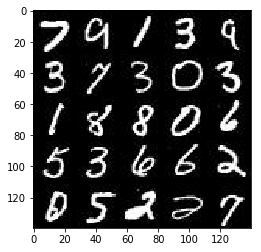

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

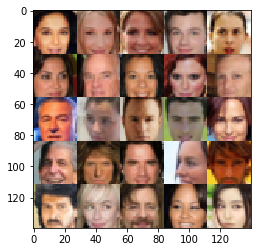

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha = 0.2, name='lrelu'):
    #with tf.variable_scope(name):
    f1 = 0.5*(1+alpha)
    f2 = 0.5*(1-alpha)
    return f1*x + f2*abs(x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3 -> 14*14*64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              # kernel_initializer = tf.random_normal_initializer(stddev=0.02))
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        # x1 = tf.maximum(0.2*x1, x1)
        x1 = lrelu(x1)
        
        # 14*14*64 -> 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides =2 , padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        
        # 7*7*128 -> 3*3*256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        
        # flatten 
        # s = x3.get_shape().as_list()
        # flat = tf.reshape(x3, (-1, s[1]*s[2]*s[3]))
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    if is_train == True:
        reuse = False
    with tf.variable_scope('generator', reuse=reuse):
        # z_dim -> 7*7*256
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        
        # 7*7*256 -> 14*14*128
        x2 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        
        # 14*14*128 -> 28*28*64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        
        # 28*28*64 -> 28*28*3
        logits = tf.layers.conv2d(x3, out_channel_dim, 5, strides=1, padding='same', 
                                 kernel_initializer = tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*np.random.uniform(0.8, 1.0)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vts = tf.trainable_variables()
    d_v = [v for v in vts if v.name.startswith('discriminator')]
    g_v = [v for v in vts if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    # x = ((x - x.min())/(255 - x.min()))
    x = ((x - x.min())/(x.max() - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        # TODO: Build Model
    tf.reset_default_graph()
    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 3
    show_every = epoch_count*100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale input images 
                scale_images = scale(batch_images)
                
                # Run optimizer 
                _= sess.run(d_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:scale_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.1565
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 1.4599
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 3.1052... Generator Loss: 0.3317
Epoch 1/2... Discriminator Loss: 1.8991... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.7277... Generator Loss: 2.0886
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 1.1319
Epoch 1/2... Discriminator Loss: 1.6666... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.9509... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 1.5318
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 1.4163
Epoch 1/2... Discriminator Loss: 2.0064... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0086
Epoch 1/2.

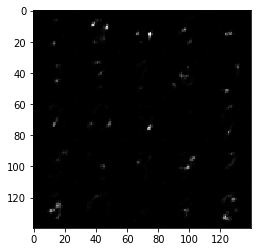

Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.4588
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 2.3584
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.4816
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 1.8265
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 2.1412
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.6708
Epoch 1/2.

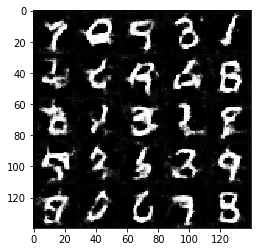

Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 1.7614
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.7530
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.2376
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 1.8316
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.8049
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.2805
Epoch 1/2.

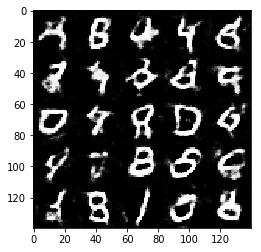

Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.6999
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.2123
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.5767
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.0978
Epoch 1/2.

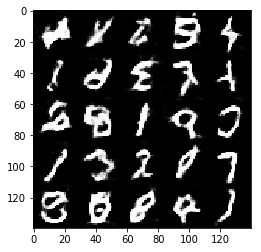

Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.2582
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 2.2712
Epoch 1/2... Discriminator Loss: 2.0584... Generator Loss: 0.4682
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.0138
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 1.7655
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.5904
Epoch 1/2.

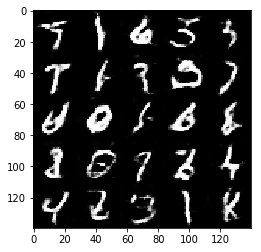

Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.2905
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 2.4176... Generator Loss: 3.1893
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 2.0131
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.8093
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.4928
Epoch 2/2.

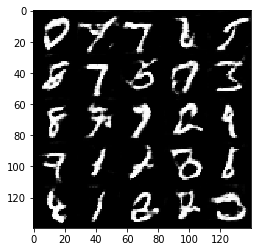

Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.4184
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 0.8833... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 4.5673... Generator Loss: 6.3189
Epoch 2/2... Discriminator Loss: 3.6530... Generator Loss: 4.6687
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 2.3880
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.4672
Epoch 2/2.

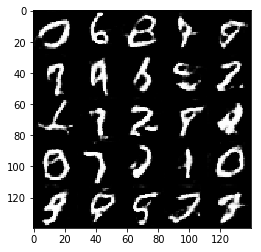

Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 1.7901
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.8384... Generator Loss: 2.9604
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.5723
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.5088
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 2.1012
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 2.3697
Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 1.7739
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.2561
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.3332
Epoch 2/2.

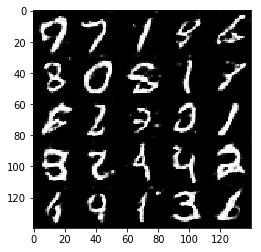

Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.4939
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.3459
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.1265
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 2.2988
Epoch 2/2... Discriminator Loss: 2.2081... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.5915
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.3699
Epoch 2/2.

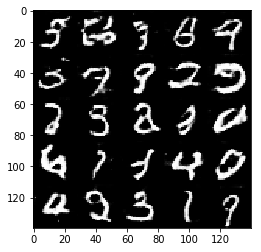

Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.9591
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 1.9681
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.6799
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.5588
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.8758
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.3453
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.4905
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.7306
Epoch 2/2... Discriminator Loss: 0.8183... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 2.3354
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 2.2095
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.2400
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.4714
Epoch 2/2.

IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 2.7236
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 2.1503
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.7153
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0145
Epoch 1/1.

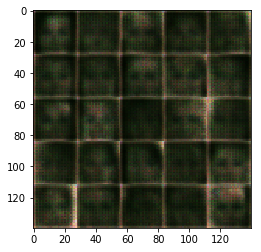

Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 3.7344
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.6646
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 4.1459
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 2.4671
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 2.0399
Epoch 1/1.

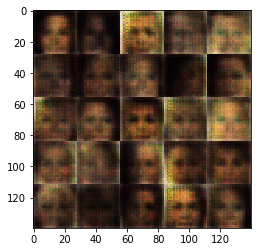

Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.9952
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 2.9039
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.7691
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 2.5976
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.4239
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 3.2570
Epoch 1/1.

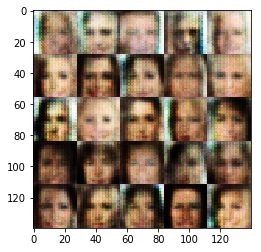

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 2.7232
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.8400
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 2.4541
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 2.6560
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.3315
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 4.1303
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 2.4140
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.1739
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 2.4719
Epoch 1/1.

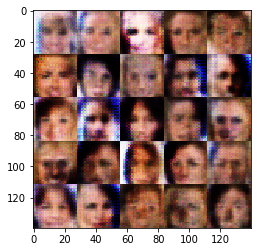

Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 2.5848
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 4.4438
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.7550
Epoch 1/1... Discriminator Loss: 2.0484... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 2.2543
Epoch 1/1.

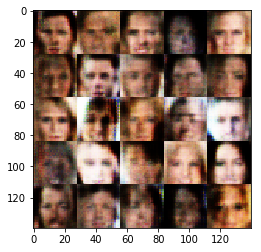

Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.7701... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 2.6346
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.6000
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 2.0525
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 3.9415
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 4.2945
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 2.7207
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 2.1166
Epoch 1/1.

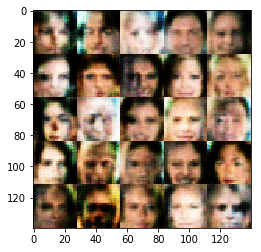

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 2.5199
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 1.8838
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 2.6269
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.5948
Epoch 1/1.

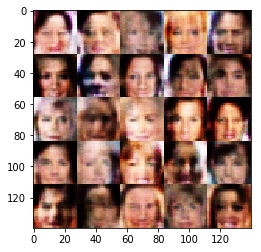

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.7054
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 2.0315
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 3.9978
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.0467
Epoch 1/1.

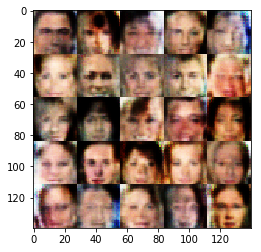

Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.9786
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.2453
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 3.5665
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.1942
Epoch 1/1.

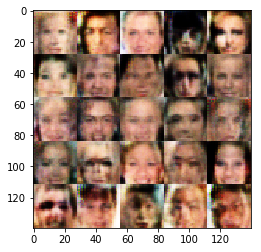

Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.9410
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 3.4932
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 2.2696
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.9069
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 3.6246
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 2.4110
Epoch 1/1.

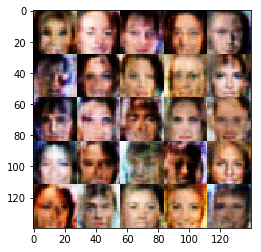

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 2.6728
Epoch 1/1... Discriminator Loss: 2.6544... Generator Loss: 2.0636
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 3.5099
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 2.7373
Epoch 1/1.

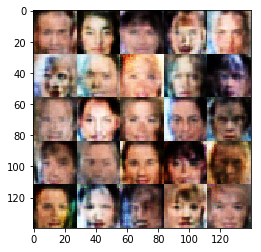

Epoch 1/1... Discriminator Loss: 1.6854... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 2.5354
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.9584
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.5370
Epoch 1/1.

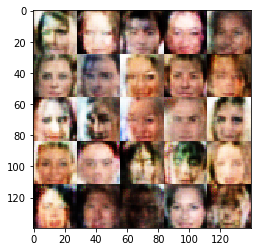

Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.0490
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 2.4846
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.8903
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 3.4312
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 2.6267


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.